In [1]:
import sys
paths_to_add = ["/homes/vk223/ProjectFlood", "/home/vkhandekar/project_flood"]
for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
print(sys.path)
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from torch.utils.data import DataLoader
from dataloaders.convLSTM_dataloader import *
from dataloaders.custom_image_transforms import *
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import date

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/vkhandekar/project_flood/.venv/lib/python3.10/site-packages', '/homes/vk223/ProjectFlood', '/home/vkhandekar/project_flood']


In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv(x)

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,
            kernel_size=kernel_size,
            padding=kernel_size // 2, #padding leads to no dimension reduction
            bias=bias
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.cell_list = nn.ModuleList([ConvLSTMCell(input_dim, hidden_dim, kernel_size)])
        for i in range(1, num_layers):
            self.cell_list.append(ConvLSTMCell(hidden_dim, hidden_dim, kernel_size))

    def forward(self, input_tensor):
        b, seq_len, c, h, w = input_tensor.size()
        hidden_states = [cell.init_hidden(b, (h, w)) for cell in self.cell_list]
        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h, c = hidden_states[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](cur_layer_input[:, t, :, :, :], (h, c))
                output_inner.append(h)
            cur_layer_input = torch.stack(output_inner, dim=1)
        return cur_layer_input[:, -1, :, :, :]

class CombinedModel(nn.Module):
    def __init__(self, preceding_rainfall_days, forecast_rainfall_days):
        super(CombinedModel, self).__init__()
        self.preceding_rainfall_days = preceding_rainfall_days
        self.forecast_rainfall_days = forecast_rainfall_days
        self.rainfall_sequence_length = preceding_rainfall_days + forecast_rainfall_days

        self.conv1 = ConvBlock(1, 16)
        self.conv2 = ConvBlock(1, 16)
        self.convlstm = ConvLSTM(1, 16, kernel_size=3, num_layers=1)
        self.final_conv = nn.Sequential(
            nn.Conv2d(48, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            # nn.Sigmoid() # No sigmoid as BCELogitsLoss as a criterion is more stable
        )

    def forward(self, x):
        b, c, h, w = x.size()
        rainfall_sequence = x[:, :self.rainfall_sequence_length].view(b, self.rainfall_sequence_length, 1, h, w)
        topology = x[:, self.rainfall_sequence_length:self.rainfall_sequence_length+1].view(b, 1, h, w)
        soil_moisture = x[:, self.rainfall_sequence_length+1:self.rainfall_sequence_length+2].view(b, 1, h, w)
        
        rainfall_out = self.convlstm(rainfall_sequence)
        topology_out = self.conv1(topology)
        soil_moisture_out = self.conv2(soil_moisture)

        combined = torch.cat([rainfall_out, topology_out, soil_moisture_out], dim=1)
        output = self.final_conv(combined) #NOcXY
        output = output.squeeze(1) #NXY
        return output

# Example usage
model = CombinedModel(1, 1)
input_data = torch.randn(8, 16, 256, 256)  # Batch size of 8, 64 sequenced images + 2 static images
output = model(input_data)
print(output.shape)  # Should be (8, 1, 256, 256)



torch.Size([8, 256, 256])


In [3]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 1
model = CombinedModel(preceding_rainfall_days=1, forecast_rainfall_days=1)
model = model.to(device)
params = list(model.parameters())

os.chdir('/home/vkhandekar/project_flood')
model_dir = 'models/saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=0.01)

# Segmentation loss
criterion = nn.BCEWithLogitsLoss()

# Datasets
train_set = FloodPredictionDataset(os.environ["PROJECT_FLOOD_DATA"], "training_labels_path", resolution=256, preceding_rainfall_days=1, forecast_rainfall_days=1, transform=train_transform)
validation_set = FloodPredictionDataset(os.environ["PROJECT_FLOOD_DATA"], "validation_labels_path", resolution=256, preceding_rainfall_days=1, forecast_rainfall_days=1, transform=train_transform)
test_set = FloodPredictionDataset(os.environ["PROJECT_FLOOD_DATA"], "test_labels_path", resolution=256, preceding_rainfall_days=1, forecast_rainfall_days=1, transform=None)

train_batch_size = 16
val_batch_size = 16
test_batch_size = 8

train_dataloader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(validation_set, batch_size=val_batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=4)

Device: cpu


In [ ]:
start = time.time()
# Train the model
num_epochs = 100
train_batch_size = 16

start = time.time()

# Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
model.train()
for epoch in range(1, 1 + num_epochs):
    start_epoch = time.time()
    for images, label in train_dataloader:
        images, label = images.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(images)
        # logits = torch.sigmoid(outputs)
        # print(outputs.shape, label.shape)
        loss = criterion(outputs, label) #pytorch does internal reshaping, BCEwithLogitsLoss means we don't need to apply sigmoid
        loss.backward()
        optimizer.step()
    print(f"Training loss, batch {epoch} :  {loss.item():.3f}")
    

torch.save(model.state_dict(), os.path.join(model_dir, f"convLSTM_separate_branch_{epoch}_{date.today().strftime(r'%Y%m%d')}.pt"))
#     # Get a batch of images and labels
#     images, label = train_set.get_random_batch(train_batch_size)
#     images, label = torch.from_numpy(images), torch.from_numpy(labels)
    
#     logits = model(images)

#     # Perform optimisation and print out the training loss
#     loss = criterion(logits, label) #pytorch does internal reshaping
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     print(f"Training loss, batch {epoch} :  {loss.item():.3f}")

#     # Evaluate
#     if epoch % 100 == 0:
#         model.eval()
#         # Disabling gradient calculation during reference to reduce memory consumption
#         with torch.no_grad():
#             # Evaluate on a batch of test images and print out the test loss
#             test_images, test_labels = test_set.get_random_batch(eval_batch_size)
#             test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
#             test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
#             test_logits = model(test_images)
#             test_loss = criterion(test_logits, test_labels)
#             print(f"Test loss, batch {epoch} :  {test_loss.item():.3f}")

#     # Save the model
#     if epoch % 10 == 0:
#         torch.save(model.state_dict(), os.path.join(model_dir, f"convLSTM_separate_branch_{epoch}.pt"))
# print(f'Training took {time.time() - start:.3f}s in total.')


In [9]:
model_path = "models/saved_models/convLSTM_separate_branch_100.pt"
model = CombinedModel(preceding_rainfall_days=1, forecast_rainfall_days=1)
model.load_state_dict(torch.load(model_path))
model.eval()

CombinedModel(
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(17, 64, kernel_size=(3, 3), st

In [10]:
# Compare vs test
test_batch_size = 8
test_dataiter = iter(test_dataloader)
test_images, test_labels = next(test_dataiter)
# test_images, test_labels = test_set.get_random_batch(4)
# test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
# test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
outputs = model(test_images)
logits = torch.sigmoid(outputs)
predictions = logits > 0.6
print(predictions.shape)


torch.Size([8, 256, 256])


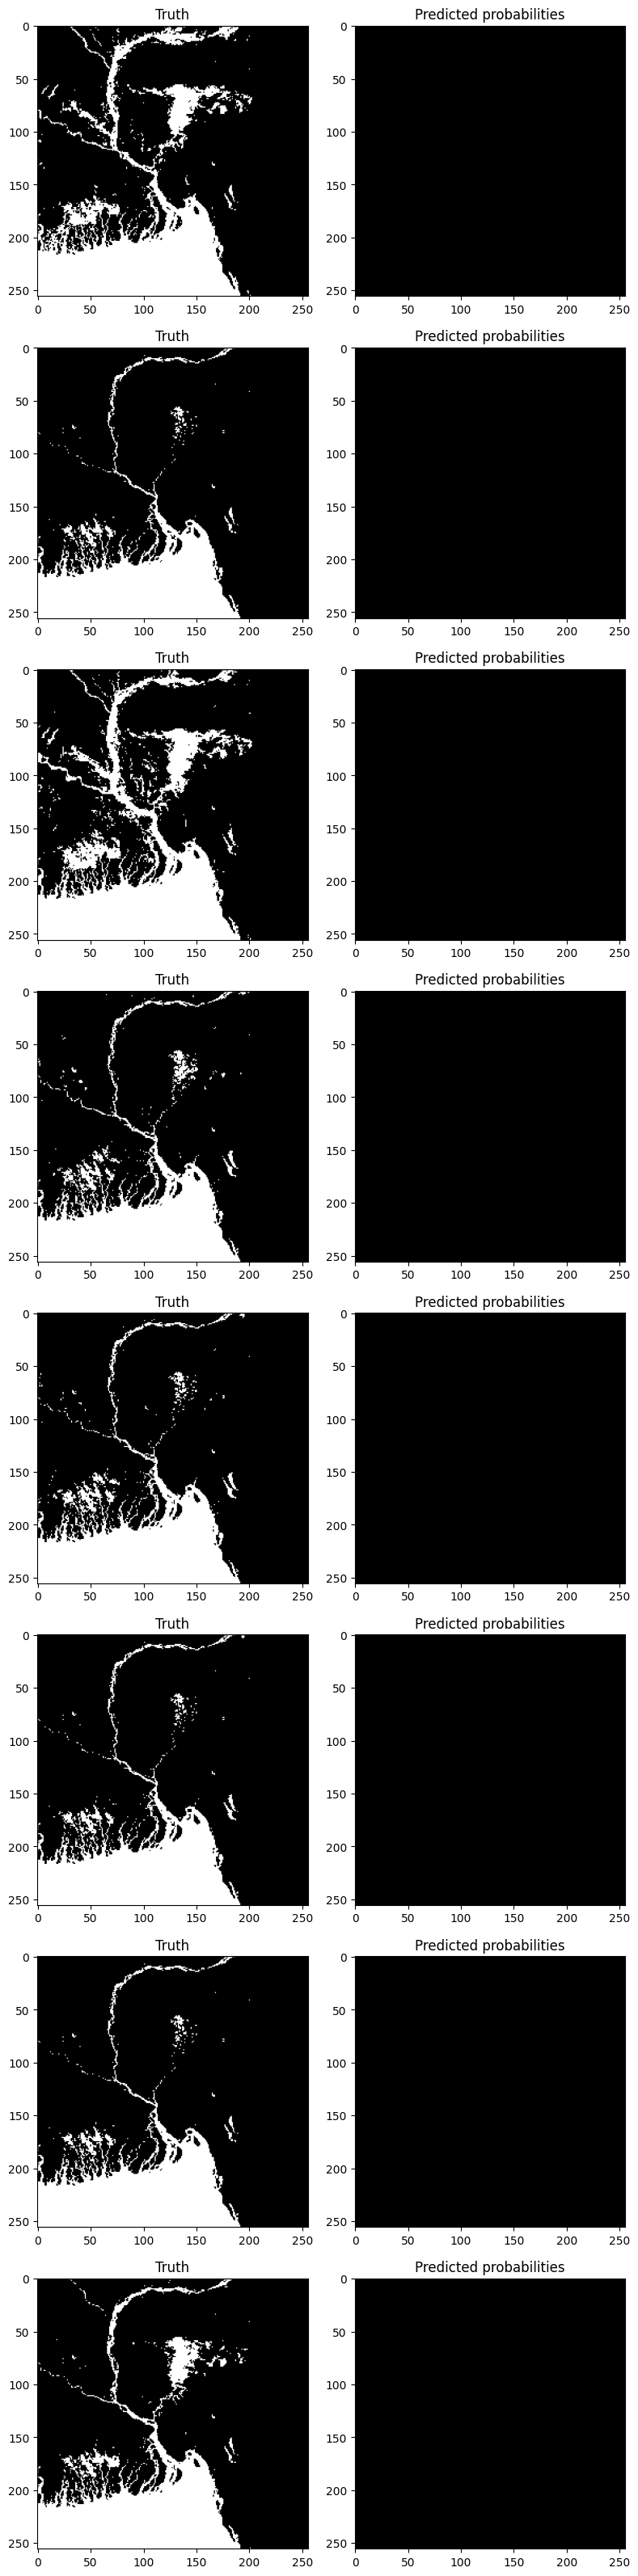

In [12]:
fig, ax = plt.subplots(8, 2, figsize=(8, 32))
# label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
plt.tight_layout()
for i in range(test_batch_size):
    ax[i, 0].imshow(test_labels[i].squeeze(0).cpu(), cmap='gray')
    ax[i, 0].set_title("Truth")

    # get logit with largest soft max probability
    # probabilities = torch.softmax(test_logits[i].cpu(), dim=0)
    # best_prediction = torch.argmax(logits, dim=0)
    ax[i, 1].imshow(predictions[i].squeeze(0).detach().cpu().numpy(), cmap='gray')
    ax[i, 1].set_title("Predicted probabilities")
